# M3 - XGBoost (all features)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.base import scope
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from joblib import dump

## Loading Dataset

In [2]:
#INPUT AND OUTPUT LOCATION FOLDER 
location = '/Users/klaaskorteweg/Desktop/Master Thesis/'

train = 'train_data_processed.xlsx'
test = 'test_data_processed.xlsx'

train_df = pd.read_excel(location+train)
test_df = pd.read_excel(location+test)

In [3]:
train_df.drop(columns=['date'], inplace=True)
train_df = train_df.astype(str)

test_df.drop(columns=['date'], inplace=True)
test_df = test_df.astype(str)

print(train_df.columns.tolist())

['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate', 'city', 'attacktype1_txt', 'targtype1_txt', 'gname', 'gsubname', 'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3', 'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday', 'quarter', 'weekend']


## Settings

In [4]:
#NAME AND CLASSIFIER ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
name = "XGBoost Classifier (all features)"
classifier = XGBClassifier()

#TARGET AND FEATURES ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target = 'targtype1_txt'
variables = ['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate',
       'city', 'attacktype1_txt', 'gname', 'gsubname',
       'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3',
       'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday',
       'quarter', 'weekend']

#FEATURE SELECTION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
selector = SelectKBest(score_func=chi2, k='all')

# TIME SERIES CROSS VALIDATION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
k_time_series_splits = 5

#HYPERPARAMETER TUNING ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
evals = 40

space = {
    'classifier__n_estimators': scope.int(hp.quniform('classifier__n_estimators', 100, 500, 50)),
    'classifier__max_depth': scope.int(hp.quniform('classifier__max_depth', 3, 30, 2)),
    'classifier__learning_rate': hp.loguniform('classifier__learning_rate', -3, 0),
    'classifier__gamma': hp.uniform('classifier__gamma', 0, 1),
    'classifier__subsample': hp.uniform('classifier__subsample', 0.5, 1),
    'classifier__colsample_bytree': hp.uniform('classifier__colsample_bytree', 0.5, 0.99)
}

# !!! Also adjust the best_parameters according to the hyperparameter search space !!!

## Time Series Cross Validation Split

In [5]:
print("Number of splits:",k_time_series_splits)

tscv = TimeSeriesSplit(n_splits=k_time_series_splits) 

for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print(f"Split {i}")
    print(f"Train: index={train_index}")
    print(f"Validation: index={val_index}")

Number of splits: 5
Split 0
Train: index=[    0     1     2 ... 27178 27179 27180]
Validation: index=[27181 27182 27183 ... 54354 54355 54356]
Split 1
Train: index=[    0     1     2 ... 54354 54355 54356]
Validation: index=[54357 54358 54359 ... 81530 81531 81532]
Split 2
Train: index=[    0     1     2 ... 81530 81531 81532]
Validation: index=[ 81533  81534  81535 ... 108706 108707 108708]
Split 3
Train: index=[     0      1      2 ... 108706 108707 108708]
Validation: index=[108709 108710 108711 ... 135882 135883 135884]
Split 4
Train: index=[     0      1      2 ... 135882 135883 135884]
Validation: index=[135885 135886 135887 ... 163058 163059 163060]


## Encoding & Pipeline

In [6]:
#Seperating variables and target for train and testing set
X_train = train_df[variables]
y_train = train_df[target]
X_test = test_df[variables]
y_test = test_df[target]

#Encoding target variable for train and testing set
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#Encoding features for pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), variables)
        ],
    remainder='drop'
)

#Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector',selector),
    ('classifier', classifier) 
    ])

## Hyperparameter Tuning
Hyperopt with Bayesian optimization

In [7]:
def objective(params):
    pipeline.set_params(**params)
    scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=tscv, scoring='accuracy')
    return -scores.mean()  

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=evals, trials=trials)

print("Best hyperparameters:", best)


100%|██████████| 40/40 [46:19<00:00, 69.49s/trial, best loss: -0.47926111274654104] 
Best hyperparameters: {'classifier__colsample_bytree': 0.7088596670717163, 'classifier__gamma': 0.8905581095905285, 'classifier__learning_rate': 0.06396682726376143, 'classifier__max_depth': 10.0, 'classifier__n_estimators': 350.0, 'classifier__subsample': 0.9205698222776664}


In [8]:
best_params = {
    'classifier__n_estimators': int(best['classifier__n_estimators']),
    'classifier__max_depth': int(best['classifier__max_depth']),
    'classifier__learning_rate': best['classifier__learning_rate'],
    'classifier__gamma': best['classifier__gamma'],
    'classifier__subsample': best['classifier__subsample'],
    'classifier__colsample_bytree': best['classifier__colsample_bytree']
}


print(best_params)

pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train_encoded)

{'classifier__n_estimators': 350, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.06396682726376143, 'classifier__gamma': 0.8905581095905285, 'classifier__subsample': 0.9205698222776664, 'classifier__colsample_bytree': 0.7088596670717163}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iyear', 'imonth', 'iday',
                                                   'country_txt', 'region_txt',
                                                   'provstate', 'city',
                                                   'attacktype1_txt', 'gname',
                                                   'gsubname', 'weaptype1_txt',
                                                   'weapsubtype1_txt', 'crit1',
                                                   'crit2', 'crit3', 'multiple',
                                                   'suicide', 'individual',
                                                   'INT_MISC', 'weekday',
                                                   'quarter', 'wee...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.06396682726376143, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=350,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [9]:
cv_scores_after_opt = cross_val_score(pipeline, X_train, y_train_encoded, cv=tscv, scoring='accuracy')
print("Tuned Model ({}):".format(name))
print("Cross-validation scores (best param.):", cv_scores_after_opt)
print("Mean CV score (best param.):", cv_scores_after_opt.mean())

Tuned Model (XGBoost Classifier (all features)):
Cross-validation scores (best param.): [0.51376214 0.40565205 0.39280983 0.51365175 0.57042979]
Mean CV score (best param.): 0.47926111274654104


In [10]:
opt_test_accuracy = pipeline.score(X_test, y_test_encoded)
opt_train_accuracy = pipeline.score(X_train, y_train_encoded)

opt_train_predictions = pipeline.predict(X_train)
opt_test_predictions = pipeline.predict(X_test)

print("Tuned Model ({}):".format(name))
print("Train accuracy",opt_train_accuracy)
print("Test accuracy",opt_test_accuracy)


Tuned Model (XGBoost Classifier (all features)):
Train accuracy 0.6253365305008555
Test accuracy 0.6050518101897596


## Summary

In [11]:
print(name)
print()
print("Time Series Split:")
print('- Number of splits:',k_time_series_splits)
print('- Split Indices:')
split_info = {}
for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    split_info[f"Split {i}"] = {'Train': f"{train_index[0]}-{train_index[-1]}", 'Val': f"{val_index[0]}-{val_index[-1]}"}
print(" ",split_info)
print()

print("Hyperparameter Tuning:")
print("- Parameter Grid:",space)
print("- Best Parameters:",best_params)

print()
print("Tuned Model:")
print("- TSCV scores (best param.):", cv_scores_after_opt)
print("- Mean TSCV score (best param.):", cv_scores_after_opt.mean())
print("- Training set accuracy:", opt_train_accuracy)
print("- Testing set accuracy:",opt_test_accuracy)


XGBoost Classifier (all features)

Time Series Split:
- Number of splits: 5
- Split Indices:
  {'Split 0': {'Train': '0-27180', 'Val': '27181-54356'}, 'Split 1': {'Train': '0-54356', 'Val': '54357-81532'}, 'Split 2': {'Train': '0-81532', 'Val': '81533-108708'}, 'Split 3': {'Train': '0-108708', 'Val': '108709-135884'}, 'Split 4': {'Train': '0-135884', 'Val': '135885-163060'}}

Hyperparameter Tuning:
- Parameter Grid: {'classifier__n_estimators': <hyperopt.pyll.base.Apply object at 0x166056a10>, 'classifier__max_depth': <hyperopt.pyll.base.Apply object at 0x1660557d0>, 'classifier__learning_rate': <hyperopt.pyll.base.Apply object at 0x166057110>, 'classifier__gamma': <hyperopt.pyll.base.Apply object at 0x166055050>, 'classifier__subsample': <hyperopt.pyll.base.Apply object at 0x166055fd0>, 'classifier__colsample_bytree': <hyperopt.pyll.base.Apply object at 0x166055ad0>}
- Best Parameters: {'classifier__n_estimators': 350, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.063966

## Error checks

In [12]:
def check_encoding(Y_train, Y_train_encoded, Y_test, Y_test_encoded):
    train_label_map = {val: label for val, label in zip(Y_train_encoded, Y_train)}
    test_label_map = {val: label for val, label in zip(Y_test_encoded, Y_test)}

    for val in set(Y_train_encoded) | set(Y_test_encoded):
        train_label = train_label_map.get(val)
        test_label = test_label_map.get(val)

        if train_label is None:
            print(f"Value {val} is present in test set but not in train set.")
        elif test_label is None:
            print(f"Value {val} is present in train set but not in test set.")
        elif train_label == test_label:
            print(f"Value {val}: {train_label} == {test_label} -- Check")
        else:
            print(f"Value {val}: {train_label} != {test_label} -- NOT EQUAL")


check_encoding(y_train, y_train_encoded, y_test, y_test_encoded)

Value 0: Business == Business -- Check
Value 1: Government (General) == Government (General) -- Check
Value 2: Military == Military -- Check
Value 3: Other == Other -- Check
Value 4: Police == Police -- Check
Value 5: Private Citizens & Property == Private Citizens & Property -- Check


## Error Analysis

[[ 8311   854    53  4904  1285  4325]
 [ 1586  8619    86  3557  2008  4254]
 [  107   282 21558   770   916  1415]
 [ 1818  2041   146 22887  2374  6768]
 [  796  1636   148  2262 12544  5183]
 [ 1378  1930   103  4967  3141 28049]]


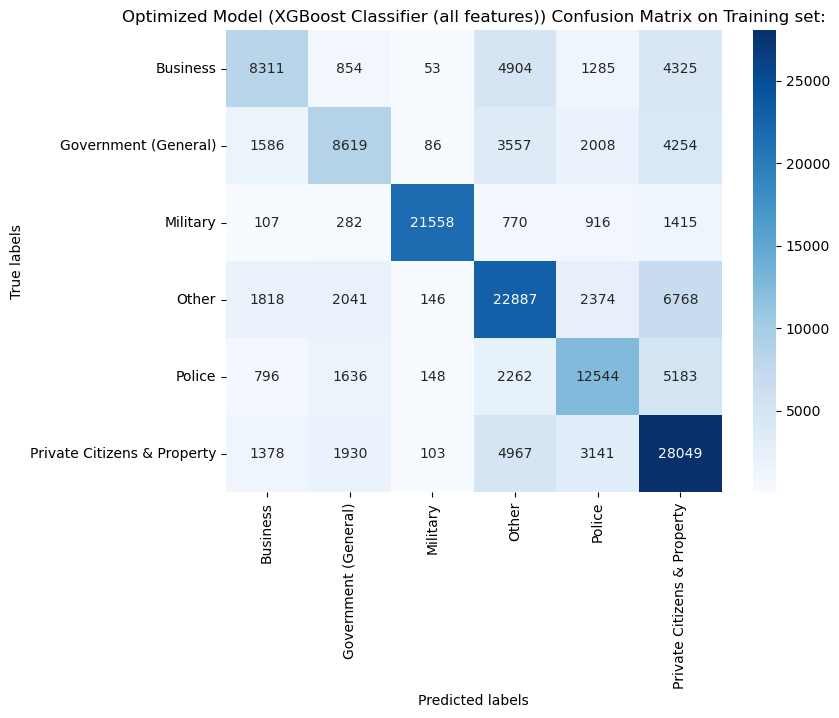

In [13]:

cm = confusion_matrix(y_train_encoded, opt_train_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Training set:".format(name))
plt.show()

[[ 327  107   13  626  191 1173]
 [  72 1529   19  488  514 1096]
 [  11   85 7886  206  344  551]
 [ 219  572   51 2219  706 2050]
 [  63  407  100  586 2951 1892]
 [ 138  752   27 1282 1248 8970]]


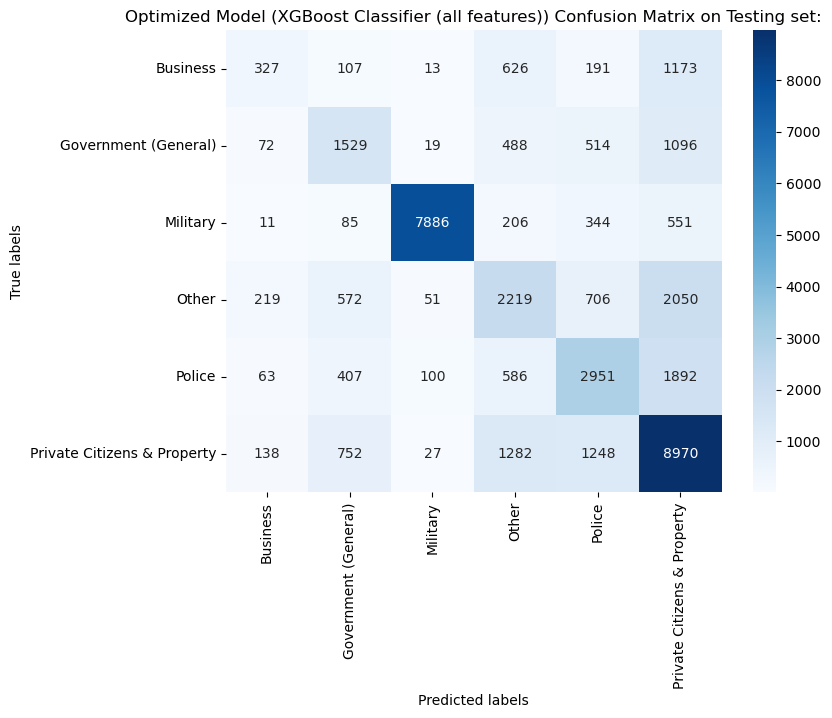

In [14]:

cm = confusion_matrix(y_test_encoded, opt_test_predictions)
print(cm)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Testing set:".format(name))
plt.show()

In [15]:
train_report = classification_report(y_train_encoded, opt_train_predictions)
print("Optimized Model ({}) Classification Report on Training set:".format(name))
print(train_report)

test_report = classification_report(y_test_encoded, opt_test_predictions)
print("Optimized Model ({}) Classification Report on Testing set:".format(name))
print(test_report)

Optimized Model (XGBoost Classifier (all features)) Classification Report on Training set:
              precision    recall  f1-score   support

           0       0.59      0.42      0.49     19732
           1       0.56      0.43      0.49     20110
           2       0.98      0.86      0.91     25048
           3       0.58      0.64      0.61     36034
           4       0.56      0.56      0.56     22569
           5       0.56      0.71      0.63     39568

    accuracy                           0.63    163061
   macro avg       0.64      0.60      0.61    163061
weighted avg       0.63      0.63      0.62    163061

Optimized Model (XGBoost Classifier (all features)) Classification Report on Testing set:
              precision    recall  f1-score   support

           0       0.39      0.13      0.20      2437
           1       0.44      0.41      0.43      3718
           2       0.97      0.87      0.92      9083
           3       0.41      0.38      0.40      5817
     

## Save Pipeline

In [16]:
filename = name + '.joblib'

dump(pipeline, filename)

['XGBoost Classifier (all features).joblib']

## Feature Importance Analysis

In [17]:
try:
    feature_importances = pipeline.named_steps['classifier'].feature_importances_
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()


    feature_names = [name.split('_', 2)[-1] for name in feature_names]

    sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

    print("Feature Importances:")
    for feature_name, importance in sorted_importances:
        print(f"{feature_name}: {importance}")
except AttributeError:
   
    raise ValueError("Feature importances are not available for the chosen classifier.")


Feature Importances:
crit3_0: 0.12343719601631165
crit3_1: 0.1120854988694191
crit2_1: 0.0051802597008645535
gname_Farabundo Marti National Liberation Front (FMLN): 0.005154765211045742
crit2_0: 0.005017971154302359
provstate_northern ireland: 0.004782620817422867
region_txt_Western Europe: 0.004239809233695269
gsubname_Opposition Party: 0.0035273893736302853
country_txt_Egypt: 0.003458933671936393
country_txt_United Kingdom: 0.0034151847939938307
country_txt_Iraq: 0.0033541249576956034
gname_Anti-Abortion extremists: 0.0031773222144693136
gname_Fulani extremists: 0.003120309906080365
country_txt_El Salvador: 0.0029924174305051565
country_txt_Afghanistan: 0.0029534443747252226
region_txt_Middle East & North Africa: 0.002791735576465726
attacktype1_txt_Facility/Infrastructure Attack: 0.002634876873344183
gname_Irish Republican Army (IRA): 0.002604053355753422
crit1_1: 0.0026025185361504555
region_txt_Central America & Caribbean: 0.002581060165539384
region_txt_Sub-Saharan Africa: 0.0025

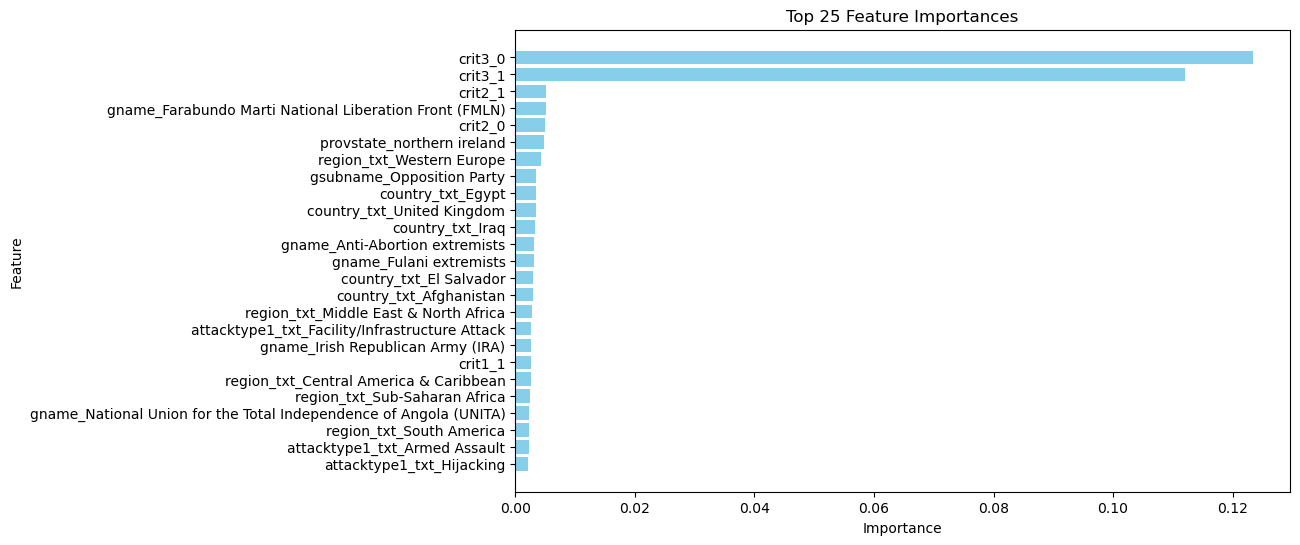

In [18]:

top_features_count = 25


top_features = [feature_name for feature_name, _ in sorted_importances[:top_features_count]]
top_importances = [importance for _, importance in sorted_importances[:top_features_count]]


plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_features_count} Feature Importances')
plt.gca().invert_yaxis()  
plt.show()


## Hyperparameter Graph

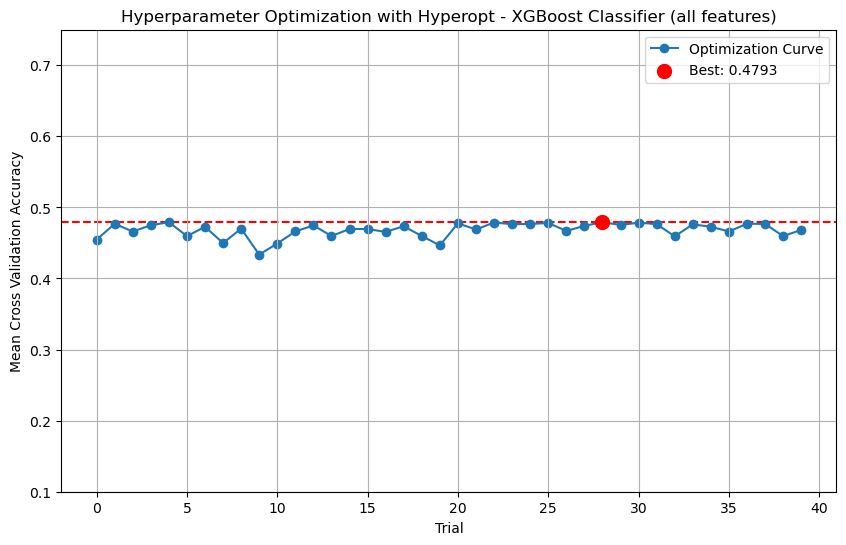

In [19]:
import matplotlib.pyplot as plt


losses = [-trial['result']['loss'] for trial in trials.trials]


plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', label='Optimization Curve', zorder=1)  
plt.xlabel('Trial')
plt.ylabel('Mean Cross Validation Accuracy')
plt.title(f'Hyperparameter Optimization with Hyperopt - {name}')
plt.grid(True)

plt.ylim(0.1, 0.75)


best_iteration = len(losses) - 1 - losses[::-1].index(max(losses))  
best_loss = max(losses)


plt.scatter([best_iteration], [best_loss], color='red', label=f'Best: {best_loss:.4f}', s=100, marker='o', zorder=2)  


plt.axhline(y=best_loss, color='red', linestyle='--', zorder=0)  
plt.legend()

plt.show()
